In [1]:
import warnings
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import textwrap

from pathlib import Path
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error, mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=['disparate_parity', 'equal_opportunity', 'group_fairness']
target_names = ['Disparate Parity', 'Equal Opportunity', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict = dict(zip(bias_score_key, target_names_w))

In [4]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
Y=df[bias_score_key]

In [5]:
cv_result_path="experiment_result/Q2_result.csv"
avg_result_path="experiment_result/Q2_average_result.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)

cv_avg_result_df=pd.DataFrame()
if Path(avg_result_path).is_file():
    cv_avg_result_df=pd.read_csv(avg_result_path,header=0,index_col=0)

## Experiments

In [6]:
#Dummy Normal Models, proved to be too irrelevent in our results
class DummyNormalPredictor:
    def __init__(self, random_state) -> None:
        self.random_state=None
        if random_state is int:
            self.random_state=random_state
        pass
    def fit(self,X,Y):
        self.mean=np.average(Y)
        self.standard_deviation=np.std(Y)
    
    def predict(self,X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        return np.random.normal(self.mean,self.standard_deviation,size=X.shape[0])


In [7]:
def symmetry_mean_aboslute_percentage_error(truth,pred):
    smape = np.abs(pred - truth) / (np.abs(truth)+np.abs(pred))*2
    output_errors = np.average(smape, axis=0)
    return output_errors

In [8]:
def cross_validatae(model, name, target,fold_settings={}):
    cv_result=[]
    #fold_settings are parameters to specified the KFold used to create training testing split in all folds
    k_fold=KFold(**fold_settings)
    for index,(train_index,test_index) in enumerate(tqdm(k_fold.split(X,Y), total=k_fold.get_n_splits(), desc=target)):

        #Train models and produce predictions based on training and testing split
        model.fit(X.loc[train_index],Y.loc[train_index][target])
        pred=model.predict(X.loc[test_index])
        truth=Y.loc[test_index][target]

        #Calculate the metrics
        mae=mean_absolute_error(truth,pred)
        mse=mean_squared_error(truth,pred)
        rmse=root_mean_squared_error(truth,pred)
        mape=mean_absolute_percentage_error(truth,pred)
        smape=symmetry_mean_aboslute_percentage_error(truth,pred)
        msle=mean_squared_log_error(np.abs(truth),np.abs(pred))
        cv_result.append({
            "Model":name,
            "Fold":index,
            "label": target,
            "MAE":mae,
            "MSE":mse,
            "RMSE":rmse,
            "MAPE":mape,
            "SMAPE":smape,
            "MSLE":msle
        })
    
    #Output results as Dataframe
    result_df=pd.DataFrame(cv_result).T
    average_row={"Model":name,"label":target}
    average_row.update(result_df.drop(columns=["Model","Fold","label"]).agg(np.average).to_dict())
    average_df=pd.DataFrame([average_row],index=[name])
    return result_df,average_df

In [9]:
# Perform Cross Validation for each model settings 
def evaluate_model(model,name,fold_settings={}):
    global cv_result_df
    global cv_avg_result_df
    if name in cv_result_df["Model"].unique():
        print(f"{name} has already been tested")
        return
    for bs in bias_score_key:
        cv_df,avg_df=cross_validatae(model,name,bs,fold_settings)
        cv_result_df=pd.concat([cv_result_df,cv_df],axis=0)
        cv_result_df.to_csv(cv_result_path)
        cv_avg_result_df=pd.concat([cv_avg_result_df,avg_df],axis=0)
        cv_avg_result_df.to_csv(avg_result_path)
        print(f"CV on model trained to predict {bs} has finished")

In [10]:
#Universal KFold training and setting split settings
fold_settings={
    "n_splits":10, 
    "shuffle":True,
    "random_state":420
}

In [11]:
evaluate_model(DummyRegressor(strategy="mean"),"NaiveMean",fold_settings)

NaiveMean has already been tested


In [12]:
evaluate_model(DummyNormalPredictor(random_state=500),"NaiveNormal",fold_settings)

NaiveNormal has already been tested


In [13]:
evaluate_model(LinearRegression(),"LinearRegression",fold_settings)

LinearRegression has already been tested


In [14]:
evaluate_model(LassoCV(cv=KFold(n_splits=5,shuffle=True,random_state=500)),"Lasso",fold_settings)

Lasso has already been tested


In [15]:
#XGBoost, LightGBM, RandomForest and MLP requires hyperparameters tuning, We use GridSearchCV to tune.
#Based on our understanding of the method, there are not risk of leakage of testing data during model training.
xgboost_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[2,5,10,15,20],
    "learning_rate":[0.01,0.3, 0.5]
}
evaluate_model(GridSearchCV(XGBRegressor(objective="reg:squarederror", n_jobs=8, seed=600, device="gpu")
            ,xgboost_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=600),scoring="neg_mean_squared_error", n_jobs=-1)
               ,"XGBoost",fold_settings)

XGBoost has already been tested


In [16]:
lightgbm_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[5,10,20,30,40],
    "learning_rate":[0.01,0.1, 0.5],
}
evaluate_model(GridSearchCV(LGBMRegressor(objective="regression", n_jobs=8, random_state =700, device_type ="gpu",verbosity=-1)
            ,lightgbm_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=700),scoring="neg_mean_squared_error", n_jobs=-1)
               ,"LightGBM",fold_settings)

LightGBM has already been tested


In [17]:
randomforest_parameters={
    "n_estimators":range(25,150,25),
    "max_depth":[5,10,20,30,40],
    "max_features":[1,0.5, "sqrt"],
}
evaluate_model(GridSearchCV(RandomForestRegressor( n_jobs=8, random_state =800)
            ,randomforest_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=800),scoring="neg_mean_squared_error", n_jobs=-1)
               ,"RandomForest",fold_settings)

RandomForest has already been tested


In [18]:
MLP_parameters={
    "hidden_layer_sizes":[(50,),(100,),(25,25),(75,25),(25,50,25),(10,30,10)],
    "solver":['sgd', 'adam'],
    "activation":['relu','logistic'],
    "learning_rate_init": [0.001,0.01,0.1]
}

evaluate_model(GridSearchCV(MLPRegressor(random_state =900,batch_size=20)
            ,MLP_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=900),scoring="neg_mean_squared_error", n_jobs=-1)
               ,"MLP",fold_settings)

MLP has already been tested


## Results

In [6]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [7]:
#Filtering out NaiveNormal models since their result will further distort the following graph 
cv_result_df = cv_result_df[cv_result_df['label'].isin(bias_score_key)]
selective_result_df=cv_result_df[cv_result_df["Model"].isin(["NaiveMean","LinearRegression","Lasso",
                                                             "LightGBM","XGBoost","RandomForest","MLP"])]
model_colors = dict(zip(selective_result_df['Model'].unique(), COLORS))

#### Overview averaged over all targets

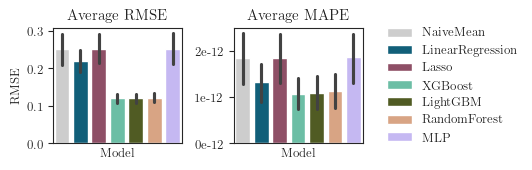

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(4, 1.5))
formatter = ticker.FuncFormatter(lambda x, pos: f'{x*1e-12:.0f}e-12')

# Left plot (all models)
sns.barplot(x='Model', y='RMSE', data=selective_result_df, ax=axes[0], 
            palette=model_colors, hue='Model', legend='brief')
axes[0].set_title('Average RMSE')
axes[0].legend(loc='center left', bbox_to_anchor=(2.5, 0.5), frameon=False)

# Right plot (only XGBoost, LightGBM, and RandomForest)
sns.barplot(x='Model', y='MAPE', data=selective_result_df, ax=axes[1], 
            palette=model_colors)
axes[1].set_ylabel('')
axes[1].set_title('Average MAPE')
axes[1].yaxis.set_major_formatter(formatter)

for ax in axes:
    ax.set_xticklabels([]) 
    ax.set_xticks([]) 

# Display the plots
plt.subplots_adjust(wspace=0.4)
plt.savefig('plots/Q2/overall_comparison_models.pdf', bbox_inches='tight')
plt.show()

#### Model comparison

In [ ]:
def display_full_result(df,metrics,save_path="", figwidth=8, trim_y=True):
    fig, axes = plt.subplots(1, len(df['label'].unique()), figsize=(figwidth,0.8), sharey=False)
    for idx, target in enumerate(df['label'].unique()):
        sns.barplot(data=df[df['label']==target], x='Model', y=metrics, ax=axes[idx], 
                    palette=model_colors, hue='Model', legend=False if idx!=2 else 'brief')
        axes[idx].set_title(target_names_dict[target])
        # axes[idx].set_xlabel(metrics)
        axes[idx].set_xticks([], [])
        if trim_y:
            axes[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        if idx>0: axes[idx].set_ylabel('')
    # axes[2].legend(ncol=4, loc='upper center', bbox_to_anchor=(1.2, -0.4), frameon=False)
    axes[2].legend(ncol=1, loc='upper left', bbox_to_anchor=(1.15, 1.7), frameon=False)
    plt.subplots_adjust(wspace=0.4)
    plt.savefig(f'plots/Q2/comparison_models_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

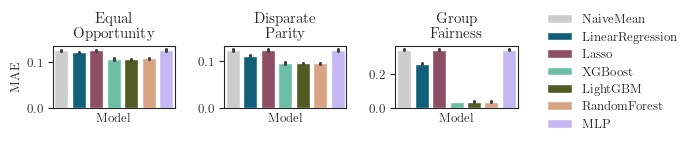

In [12]:
display_full_result(selective_result_df,"MAE", trim_y=False, figwidth=6)

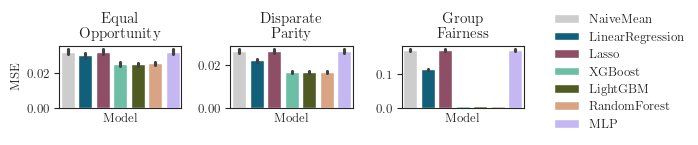

In [13]:
display_full_result(selective_result_df,"MSE", trim_y=False, figwidth=6)

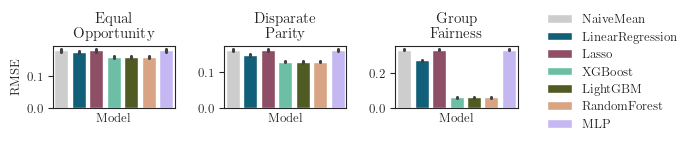

In [11]:
display_full_result(selective_result_df,"RMSE", figwidth=6)

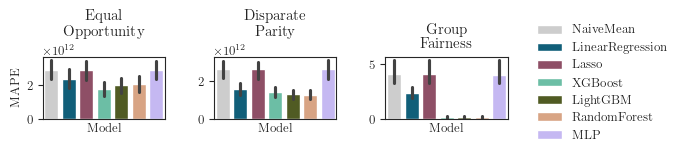

In [14]:
display_full_result(selective_result_df,"MAPE", trim_y=False, figwidth=6)

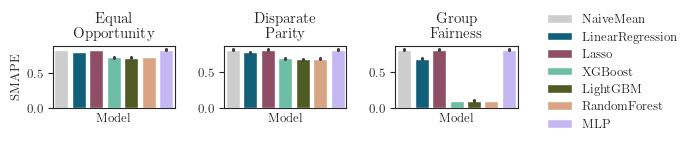

In [15]:
display_full_result(selective_result_df,"SMAPE", figwidth=6)

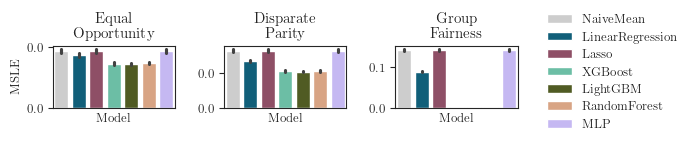

In [16]:
display_full_result(selective_result_df,"MSLE", figwidth=6)

In [14]:
def display_full_result_box(df,metrics,save_path="_box", figwidth=8, trim_y=1):
    fig, axes = plt.subplots(1, len(df['label'].unique()), figsize=(figwidth,0.8), sharey=False)
    for idx, target in enumerate(df['label'].unique()):
        sns.boxplot(data=df[df['label']==target], x='Model', y=metrics, ax=axes[idx], 
                    palette=model_colors, hue='Model', legend=False if idx!=2 else 'brief', linewidth=0.5, fliersize=0.5)
        axes[idx].set_title(target_names_dict[target])
        # axes[idx].set_xlabel(metrics)
        axes[idx].set_xticks([], [])
        axes[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter(f'%.{trim_y}f'))
        if idx>0: axes[idx].set_ylabel('')
    # axes[2].legend(ncol=4, loc='upper center', bbox_to_anchor=(1.2, -0.4), frameon=False)
    axes[2].legend(ncol=1, loc='upper left', bbox_to_anchor=(1.15, 1.7), frameon=False)
    plt.subplots_adjust(wspace=0.4)
    plt.savefig(f'plots/Q2/comparison_models_{metrics}{save_path}.eps', bbox_inches='tight')
    plt.savefig(f'plots/Q2/comparison_models_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

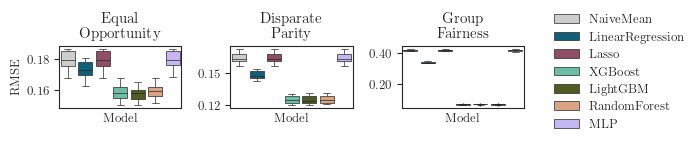

In [15]:
display_full_result_box(selective_result_df,"RMSE", figwidth=6, trim_y=2)

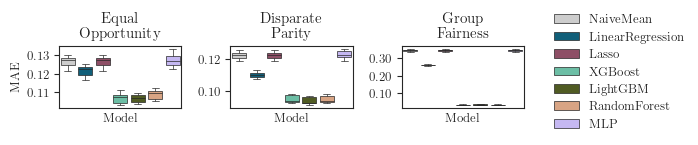

In [16]:
display_full_result_box(selective_result_df,"MAE", figwidth=6, trim_y=2)

In [ ]:
def display_full_result_same_y(df,metrics,save_path="", figwidth=9, figheight=1.4):
    g = sns.catplot(kind='bar', palette=model_colors, legend='brief', 
                aspect=figwidth/figheight, height=figheight,
                data=df, x='label', y=metrics, hue='Model')
    new_labels = [target_names_dict[label.get_text()] for label in g.ax.get_xticklabels()]
    g.ax.set_xticklabels(new_labels)
    g.ax.set_xlabel("")
    plt.savefig(f'Plots/Q2/comparison_models_samey_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

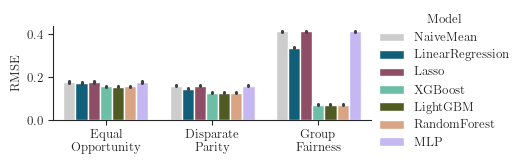

In [27]:
display_full_result_same_y(selective_result_df, "RMSE", figwidth=4, figheight=1.8)

#### Best models only

In [28]:
#Have a closer look on XGBoost, LightGBM, and RandomForest
more_selective_result_df=cv_result_df[cv_result_df["Model"].isin(["NaiveMean","XGBoost","LightGBM","RandomForest"])]

In [42]:
def display_selective_result(df,metrics,save_path="", figwidth=9, figheight=1.4):
    g = sns.catplot(kind='bar', palette=model_colors, legend='brief', 
                aspect=figwidth/figheight, height=figheight,
                data=df, x='label', y=metrics, hue='Model')
    new_labels = [target_names_dict[label.get_text()] for label in g.ax.get_xticklabels()]
    g.ax.set_xticklabels(new_labels)
    g.ax.set_xlabel("")
    plt.savefig(f'plots/Q2/comparison_models_selective_{metrics}{save_path}.eps', bbox_inches='tight')
    plt.savefig(f'plots/Q2/comparison_models_selective_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

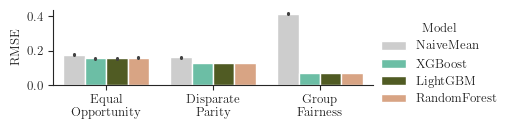

In [43]:
display_selective_result(more_selective_result_df, 'RMSE', figwidth=4)

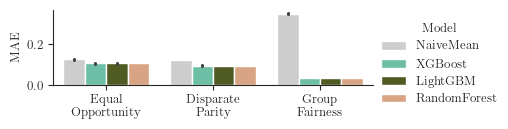

In [31]:
display_selective_result(more_selective_result_df, 'MAE', figwidth=4)

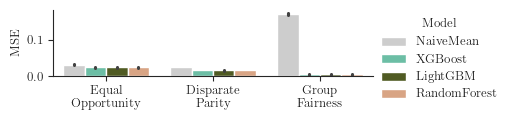

In [32]:
display_selective_result(more_selective_result_df, 'MSE', figwidth=4)

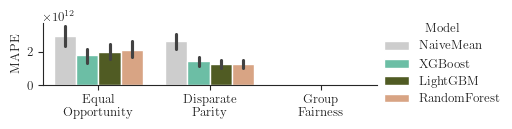

In [33]:
display_selective_result(more_selective_result_df, 'MAPE', figwidth=4)

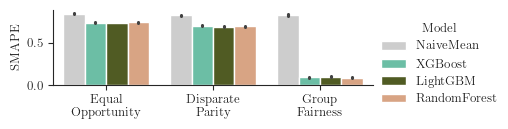

In [34]:
display_selective_result(more_selective_result_df, 'SMAPE', figwidth=4)

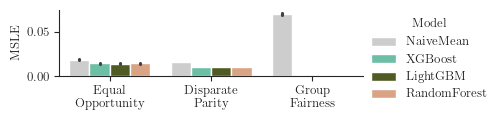

In [35]:
display_selective_result(more_selective_result_df, 'MSLE', figwidth=4)